<a href="https://colab.research.google.com/github/Bovi-analytics/hut-et-al-2021/blob/master/LegActivity_24h_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for leg activity/number of steps

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching

In [ ]:
%%R
options(warn=-1)

## Data loading into dataframe

In [ ]:
%%R

#path <- "/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=LegActivityStepsPer2Hours/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-13.c000.csv"
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=LegActivityStepsPer2Hours/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-13.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, 1, 10)) %>%
  dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    Parity = factor(TransitionParity),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType) %>%
  tidyr::drop_na()

|===================================================================| 100% 54 MB


In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 x 8
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk CalvingSeason Hour 
  <fct>            <fct>          <fct>  <fct>        <fct>         <fct>
1 104              2297           1      6            Autumn        18   
2 104              2297           2      3            Autumn        18   
3 600              2514           3+     10           Summer        14   
4 600              2514           3+     6            Summer        4    
5 9131             2011           2      1            Winter        2    
6 9131             2011           2      7            Winter        12   
# … with 2 more variables: SensorValue <dbl>, MilkingType <fct>


In [ ]:
%%R
str(AnalysisData)

tibble[,8] [429,091 × 8] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1053 levels "1","2","3","4",..: 104 104 248 248 947 947 947 975 317 119 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 2 2 3 3 1 1 1 1 3 7 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 1 2 3 3 2 2 2 3 3 1 ...
 $ MonthsInMilk    : Factor w/ 10 levels "1","2","3","4",..: 6 3 10 6 1 7 6 1 6 1 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 1 1 3 3 4 4 4 4 1 3 ...
 $ Hour            : Factor w/ 12 levels "0","2","4","6",..: 10 10 8 3 2 7 8 1 6 8 ...
 $ SensorValue     : num [1:429091] 458.3 275 143.3 87.8 271.7 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 2 2 1 1 2 2 2 2 1 1 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>% group_by("Parity") %>% n_distinct()

[1] 429073


In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 x 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  698
2 2                  690
3 3+                 729


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 x 1
  Unique_Elements
            <int>
1            1053


# Model building

First we determine the null model

## Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1| HerdIdentifier:AnimalIdentifier), 
                  data = AnalysisData
                  )


## Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 5853172 5853205 -2926583  5853166                         
Model1.0   12 5851625 5851756 -2925800  5851601 1565.4  9  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 5853172 5853205 -2926583  5853166                         
Model1.1    5 5851064 5851119 -2925527  5851054 2112.3  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  HerdIdentifier + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.2: SensorValue ~ HerdIdentifier + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 5853172 5853205 -2926583  5853166                         
Model1.2   10 5852120 5852229 -2926050  5852100 1066.5  7  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.3: SensorValue ~ CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 5853172 5853205 -2926583  5853166                         
Model1.3    6 5852631 5852697 -2926310  5852619 547.04  3  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.4,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.4: SensorValue ~ Hour + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq Df Pr(>Chisq)    
Model.0     3 5853172 5853205 -2926583  5853166                        
Model1.4   14 5765090 5765243 -2882531  5765062 88105 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.5 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.5,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.5: SensorValue ~ MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 5853172 5853205 -2926583  5853166                         
Model1.5    4 5852355 5852399 -2926174  5852347 818.83  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason + Hour + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
    MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
              npar     AIC   LRT   Pr(Chi)    
<none>             5758763                    
Parity           2 5761613  2853 < 2.2e-16 ***
MonthsInMilk     9 5761140  2395 < 2.2e-16 ***
CalvingSeason    3 5759441   684 < 2.2e-16 ***
Hour            11 5847815 89074 < 2.2e-16 ***
MilkingType      1 5759596   835 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + Hour + HerdIdentifier + CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + Hour + HerdIdentifier + 
Model2.1:     CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 5758763 5759082 -2879353  5758705                         
Model2.1   53 5757804 5758386 -2878849  5757698 1006.9 24  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + Parity + Hour + CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * MilkingType + Parity + Hour + CalvingSeason + 
Model2.2:     (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 5758763 5759082 -2879353  5758705                         
Model2.2   38 5758695 5759112 -2879309  5758619 86.486  9  8.234e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + Hour + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + Hour + 
Model2.3:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   29 5758763 5759082 -2879353  5758705                        
Model2.3   56 5722971 5723585 -2861429  5722859 35847 27  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Interactions with hour

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*Parity + MonthsInMilk + CalvingSeason + MilkingType + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.4: SensorValue ~ Hour * Parity + MonthsInMilk + CalvingSeason + 
Model2.4:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 5758763 5759082 -2879353  5758705                         
Model2.4   51 5756714 5757273 -2878306  5756612 2093.7 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*MilkingType + MonthsInMilk + CalvingSeason + Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.5: SensorValue ~ Hour * MilkingType + MonthsInMilk + CalvingSeason + 
Model2.5:     Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   29 5758763 5759082 -2879353  5758705                        
Model2.5   40 5736090 5736529 -2868005  5736010 22696 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.6 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*CalvingSeason + MonthsInMilk +  + Parity + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.6,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.6: SensorValue ~ Hour * CalvingSeason + MonthsInMilk + +Parity + 
Model2.6:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 5758763 5759082 -2879353  5758705                         
Model2.6   62 5755632 5756312 -2877754  5755508 3197.2 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.7 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType + 
                  MonthsInMilk*CalvingSeason + 
                  Hour*Parity + 
                  Hour*MilkingType + 
                  Hour*CalvingSeason + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.7,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.7: SensorValue ~ MonthsInMilk * Parity + MonthsInMilk * MilkingType + 
Model2.7:     MonthsInMilk * CalvingSeason + Hour * Parity + Hour * MilkingType + 
Model2.7:     Hour * CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   29 5758763 5759082 -2879353  5758705                         
Model2.7  149 5693477 5695111 -2846589  5693179 65527 120  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model analysis of variance

In [ ]:
%%R
finalModel <- Model2.7

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                               Chisq Df Pr(>Chisq)    
MonthsInMilk                 2799.39  9  < 2.2e-16 ***
Parity                       4201.22  2  < 2.2e-16 ***
MilkingType                  1034.22  1  < 2.2e-16 ***
CalvingSeason                 788.86  3  < 2.2e-16 ***
Hour                       115440.93 11  < 2.2e-16 ***
MonthsInMilk:Parity          1000.08 18  < 2.2e-16 ***
MonthsInMilk:MilkingType      203.76  9  < 2.2e-16 ***
MonthsInMilk:CalvingSeason  40295.15 27  < 2.2e-16 ***
Parity:Hour                  1499.81 22  < 2.2e-16 ***
MilkingType:Hour            23644.85 11  < 2.2e-16 ***
CalvingSeason:Hour           2164.37 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodel2hourslegactivity.rdata")

# Final model figures and LSM (95% CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 429091' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 429091' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MonthsInMilk lsmean   SE  df asymp.LCL asymp.UCL .group   
 10              303 1.87 Inf       297       308  a       
 9               305 1.87 Inf       300       311  ab      
 8               308 1.87 Inf       302       313   bc     
 7               311 1.87 Inf       306       316    c     
 6               317 1.87 Inf       312       323     d    
 5               320 1.87 Inf       314       325     d    
 4               325 1.87 Inf       319       330      e   
 3               333 1.88 Inf       328       338       f  
 2               343 1.89 Inf       338       348        g 
 1               364 1.89 Inf       359       369         h

Results are averaged over the levels of: Parity, MilkingType, CalvingSeason, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 10 estimates 
P value adjustment: tukey method for comparing a family of 10 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 429091' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 429091' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean   SE  df asymp.LCL asymp.UCL .group
 3+        296 1.67 Inf       292       300  a    
 2         316 1.70 Inf       312       320   b   
 1         356 1.71 Inf       352       360    c  

Results are averaged over the levels of: MonthsInMilk, MilkingType, CalvingSeason, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Hour), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 429091' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 429091' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Hour lsmean   SE  df asymp.LCL asymp.UCL .group    
 2       180 1.92 Inf       174       185  a        
 0       210 1.92 Inf       205       216   b       
 22      229 1.92 Inf       224       235    c      
 4       254 1.92 Inf       249       260     d     
 20      265 1.92 Inf       260       271      e    
 18      341 1.92 Inf       336       347       f   
 16      386 1.92 Inf       380       391        g  
 12      389 1.92 Inf       384       395        g  
 6       398 1.92 Inf       392       403         h 
 14      399 1.92 Inf       394       405         h 
 10      400 1.92 Inf       394       405         h 
 8       423 1.92 Inf       418       429          i

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType, CalvingSeason 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 estimates 
P value adjustment: tukey method for comparing a family of 12 estimates 
significance level used:

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 429091' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 429091' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean   SE  df asymp.LCL asymp.UCL .group
 Summer           303 1.77 Inf       299       308  a    
 Autumn           314 1.77 Inf       310       319   b   
 Spring           333 1.81 Inf       329       338    c  
 Winter           341 1.81 Inf       336       345     d 

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


## Interactions

### Hour by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 429091' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 429091' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Parity = 1:
 Hour lsmean   SE  df asymp.LCL asymp.UCL .group     
 2       190 2.55 Inf       182       197  a         
 0       223 2.55 Inf       215       230   b        
 22      247 2.55 Inf       239       254    c       
 4       284 2.55 Inf       277       292     d      
 20      294 2.55 Inf       287       302      e     
 18      377 2.55 Inf       370       384       f    
 16      429 2.55 Inf       422       436        g   
 6       433 2.55 Inf       425       440        g   
 12      436 2.55 Inf       429       444        gh  
 14      444 2.55 Inf       437       452         hi 
 10      447 2.55 Inf       439       454          i 
 8       472 2.55 Inf       465       479           j

Parity = 2:
 Hour lsmean   SE  df asymp.LCL asymp.UCL .group     
 2       174 2.53 Inf       166       181  a         
 0       206 2.53 Inf       199       213   b        
 22      223 2.53 Inf       216       230    c       
 4       243 2.53 Inf       236       251     d      
 20

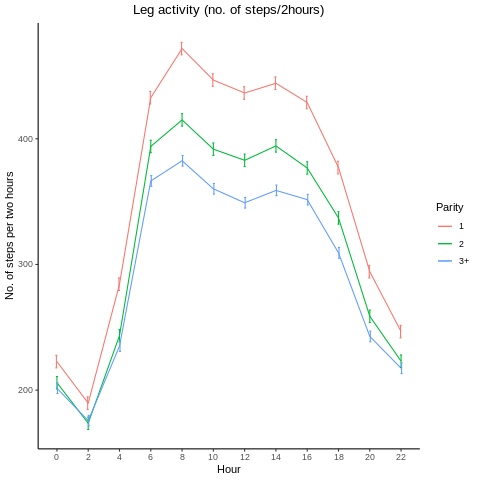

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Leg activity (no. of steps/2hours)", 
    y="No. of steps per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### Hour by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 429091' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 429091' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



MilkingType = AMS:
 Hour lsmean   SE  df asymp.LCL asymp.UCL .group      
 2       174 3.16 Inf       165       183  a          
 4       193 3.16 Inf       184       202   b         
 0       213 3.16 Inf       204       222    c        
 22      230 3.16 Inf       221       240     d       
 20      269 3.16 Inf       260       278      e      
 6       290 3.16 Inf       281       299       f     
 10      291 3.16 Inf       282       300       fg    
 12      299 3.16 Inf       289       308        g    
 14      310 3.16 Inf       301       319         h   
 8       314 3.16 Inf       305       323         h   
 16      334 3.16 Inf       325       343          i  
 18      335 3.16 Inf       326       344          i  

MilkingType = CMS:
 Hour lsmean   SE  df asymp.LCL asymp.UCL .group      
 2       185 2.15 Inf       179       191  a          
 0       207 2.15 Inf       201       213   b         
 22      228 2.15 Inf       221       234    c        
 20      262 2.15 Inf     

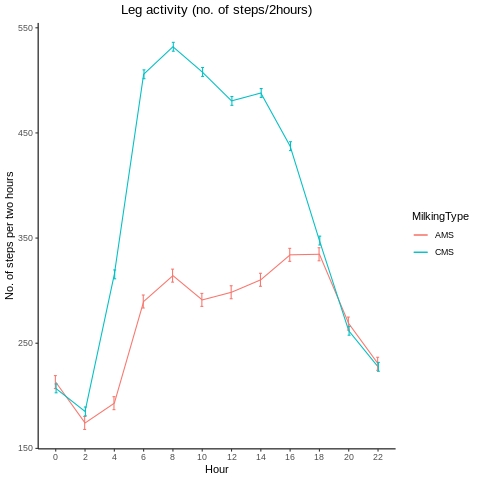

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(MilkingType), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=MilkingType, 
    color=MilkingType)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Leg activity (no. of steps/2hours)", 
    y="No. of steps per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### Hour by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 429091' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 429091' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 429091)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 Hour lsmean   SE  df asymp.LCL asymp.UCL .group     
 2       181 2.55 Inf       173       188  a         
 0       212 2.55 Inf       205       219   b        
 22      231 2.55 Inf       224       238    c       
 4       247 2.55 Inf       239       254     d      
 20      269 2.55 Inf       262       276      e     
 18      343 2.55 Inf       336       351       f    
 14      372 2.55 Inf       365       379        g   
 12      372 2.55 Inf       365       380        g   
 6       378 2.55 Inf       371       385        g   
 16      379 2.55 Inf       372       387        gh  
 10      388 2.55 Inf       380       395         h  
 8       398 2.55 Inf       391       405          i 

CalvingSeason = Spring:
 Hour lsmean   SE  df asymp.LCL asymp.UCL .group     
 2       182 2.73 Inf       174       190  a         
 0       211 2.73 Inf       203       218   b        
 22      229 2.73 Inf       222       237    c       
 4       261 2.73 Inf       253  

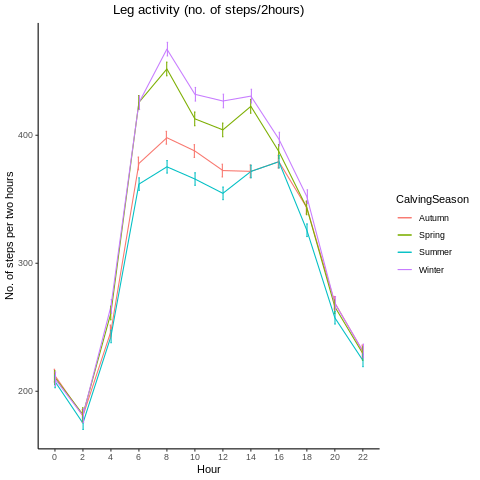

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Leg activity (no. of steps/2hours)", 
    y="No. of steps per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))